# CIVIL-534 Project: Sustainable Development Simulation

## Team Members
- **Meera Mahadevan**
- **Sudhanva Rajashekar**
- **Ismaïl Sahbane**
- **Yanpeng Zhang**

## Overview
This is the main notebook for the **Sustainable Development Project**.  
We explore system dynamics using the **World3 model** to evaluate the long-term impact of policy decisions on key indicators such as population, industrial output, food production, and pollution.

## Associated Scripts
- [`grid_search.py`](./grid_search.py)  
  Performs a grid search over selected parameter spaces to identify the best-performing model configurations.

- [`differential_evolution.py`](./differential_evolution.py)  
  Uses a differential evolution algorithm for efficient global optimization of model parameters.

- [`run_and_plot.py`](./run_and_plot.py)  
  Runs the World3 simulation with given parameters and visualizes key system variables over time.


Imports from libraries and scripts

In [8]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from grid_search import grid_search
from differential_evolution import callback_func, obj
from scipy.optimize import differential_evolution
from run_and_plot import simulate_world3

Loading the World3 model as a networkx graph

In [9]:
# Load the JSON data
json_file = open('world3-03_variables.json')
w3_vars = json.loads(json_file.read())
json_file.close()

# Create directed graph
G = nx.DiGraph()
for name, val in w3_vars.items():
    G.add_node(name, var_type=val['type'])
    if val['dependencies'] is not None:
        G.add_edges_from([(dep, name) for dep in val['dependencies']])

Getting the Centrality measures that we want to use for defining the set of tunable variables

In [10]:
# === Compute Katz Centrality on the reversed graph ===
# Katz centrality identifies nodes that are influential by considering the influence of their neighbors.
# By reversing the graph (G_T), we calculate "left" Katz centrality, 
# which emphasizes influence flowing out from nodes (i.e., how much a node influences others).
G_T = G.reverse(copy=True)

# Compute Katz centrality on the reversed graph with a max iteration of 1000 to ensure convergence.
katz = nx.katz_centrality(G_T, max_iter=1000)

# Filter the graph nodes to only those whose type is 'constant'
# This is because we want to focus on constants in the model
constant_nodes = [node for node in G.nodes if G.nodes[node]['var_type'] == 'constant']

# Create a list of tuples (node, katz_score) for constant nodes,
# then sort this list in descending order by Katz centrality score.
# Taking the top 100 just in case you want to display more than 20 later.
top_20_constants = sorted(
    [(node, katz.get(node, 0)) for node in constant_nodes],
    key=lambda x: x[1],
    reverse=True
)[:20]

# Print the top constant nodes by Katz centrality
# Include node name, abbreviation (abbr), type, and Katz centrality score.
print("\nTop 20 constant nodes by Left Katz Centrality (influence):")
for rank, (node, score) in enumerate(top_20_constants, start=1):
    abbr = w3_vars[node].get("abbr", "N/A")  # Get abbreviation from your variable metadata
    print(f"{rank}. Node: {node}, abbr: {abbr}, Type: constant, Katz: {score:.4f}")



Top 20 constant nodes by Left Katz Centrality (influence):
1. Node: policy_year, abbr: PYEAR, Type: constant, Katz: 0.1337
2. Node: gdp_pc_unit, abbr: None, Type: constant, Katz: 0.1291
3. Node: one_year, abbr: None, Type: constant, Katz: 0.0890
4. Node: unit_agricultural_input, abbr: None, Type: constant, Katz: 0.0620
5. Node: technology_development_delay, abbr: TDD, Type: constant, Katz: 0.0615
6. Node: inherent_land_fertility, abbr: ILF, Type: constant, Katz: 0.0614
7. Node: ha_per_gha, abbr: None, Type: constant, Katz: 0.0611
8. Node: price_of_food, abbr: None, Type: constant, Katz: 0.0597
9. Node: subsistence_food_per_capita, abbr: SFPC, Type: constant, Katz: 0.0570
10. Node: initial_nonrenewable_resources, abbr: NRI, Type: constant, Katz: 0.0567
11. Node: health_services_impact_delay, abbr: HSID, Type: constant, Katz: 0.0567
12. Node: potentially_arable_land_total, abbr: PALT, Type: constant, Katz: 0.0563
13. Node: ind_out_in_1970, abbr: IO70, Type: constant, Katz: 0.0562
14. No

Selcting 5 tunable nodes + policy year (fixed) for the optimization problem.

For Left Katz centrality, we select:
- policy year
- persistent pollution generation factor
- average life of agricultural inputs
- health services impact delay
- industrial material toxicity index
- desired complete family size

For these we slect ranges based on the defualt values in the world3 model. We then run the grid search algorithm to find the best parameters for the model.

searching ranges: [array([1975, 2010, 2025, 2030]), array([0.5, 1. , 1.5]), array([1, 2, 5]), array([ 5, 10, 20, 30]), array([15, 10,  5,  1]), array([1, 2, 4, 6])]
total_steps: 2304
Found new best param set: (np.int64(1975), np.float64(0.5), np.int64(1), np.int64(5), np.int64(15), np.int64(1))
    New best metric: 0.14252562417780648
Iteration time: 1.0148420333862305
Total estimation: 2338.196044921875[s], or 38.96993408203125 mins.
Found new best param set: (np.int64(1975), np.float64(0.5), np.int64(1), np.int64(5), np.int64(10), np.int64(1))
    New best metric: 0.17706148522773088
Found new best param set: (np.int64(1975), np.float64(0.5), np.int64(1), np.int64(5), np.int64(5), np.int64(1))
    New best metric: 0.20438440868369104
Found new best param set: (np.int64(1975), np.float64(0.5), np.int64(1), np.int64(5), np.int64(5), np.int64(2))
    New best metric: 0.2225873125598066
Found new best param set: (np.int64(1975), np.float64(0.5), np.int64(1), np.int64(5), np.int64(1), np.

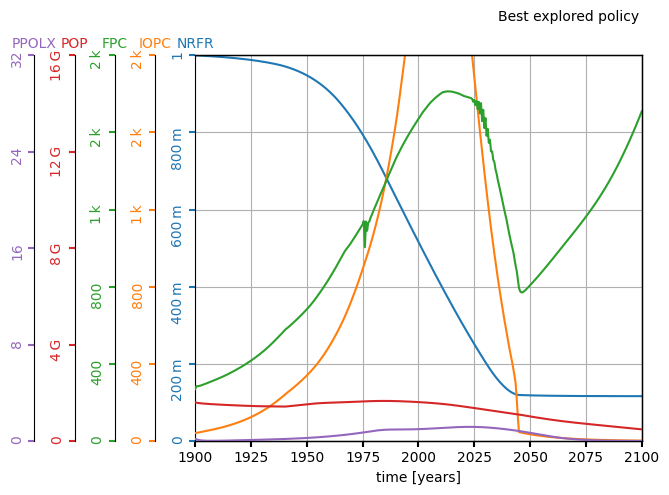

In [11]:
# === Parameter grids for Grid Search ===
# Each element is an np.array of discrete candidate values for the respective parameter
parameters_ranges_gs = [
    np.array([1975, 2010, 2025, 2030]),     # pyear - policy year (discrete years)
    np.array([0.5, 1, 1.5]),               # ppgf - pollution generation factor (discrete steps)
    np.array([1, 2, 5]),                   # alai2 - average life agricultural input multiplier
    np.array([5, 10, 20, 30]),             # hsid - health service impact delay (in years)
    np.array([15, 10, 5, 1]),              # imti - industrial material toxicity index (note order descending)
    np.array([1, 2, 4, 6])                 # dcfs - desired number of children (discrete options)
]

gs_best_score, gs_best_set = grid_search(parameters_ranges_gs) 
#removing the data type from the grid search results
cleaned_set = tuple(map(lambda x: x.item() if hasattr(x, 'item') else x, gs_best_set))
print("Grid Search Best Set:", cleaned_set)
print("Grid Search Best Score:", gs_best_score)
simulate_world3(cleaned_set)


We now do the same with the differential evolution algorithm.

differential_evolution step 1: f(x)= -0.27406989063839643
Iteration 21: Current best evaluation metric = 0.27407
differential_evolution step 2: f(x)= -0.29680112373225026
Iteration 22: Current best evaluation metric = 0.29680
differential_evolution step 3: f(x)= -0.29680112373225026
Iteration 23: Current best evaluation metric = 0.29680
differential_evolution step 4: f(x)= -0.30224848135144045
Iteration 24: Current best evaluation metric = 0.30225
differential_evolution step 5: f(x)= -0.31455903954370545
Iteration 25: Current best evaluation metric = 0.31456
differential_evolution step 6: f(x)= -0.31455903954370545
Iteration 26: Current best evaluation metric = 0.31456
differential_evolution step 7: f(x)= -0.31455903954370545
Iteration 27: Current best evaluation metric = 0.31456
differential_evolution step 8: f(x)= -0.31455903954370545
Iteration 28: Current best evaluation metric = 0.31456
differential_evolution step 9: f(x)= -0.31455903954370545
Iteration 29: Current best evaluation 

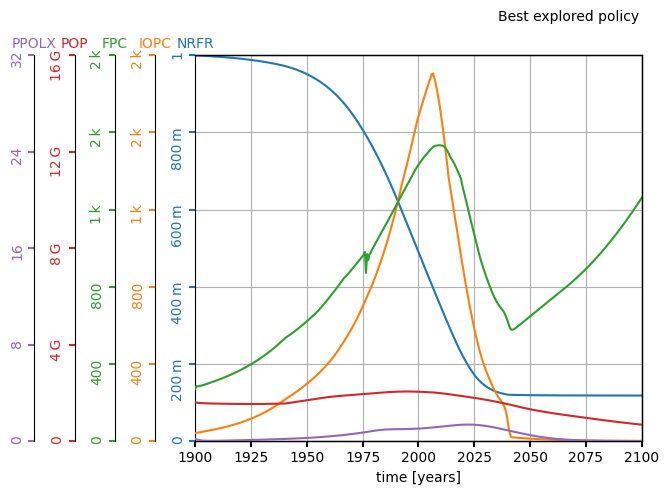

In [12]:
# === Parameter bounds for Differential Evolution ===
# Each tuple defines the lower and upper bound for continuous parameters
parameters_ranges_de = [
    (1975, 2050),   # pyear - policy year (continuous range)
    (0.5, 1.5),     # ppgf - pollution generation factor
    (1, 5),         # alai2 - average life agricultural input multiplier
    (5, 30),        # hsid - health service impact delay
    (1, 15),        # imti - industrial material toxicity index
    (1, 6)          # dcfs - desired number of children
]

# Run the differential evolution optimizer with your objective function `obj`
result_de = differential_evolution(
    obj,
    parameters_ranges_de,
    maxiter=10,        # maximum iterations
    popsize=50,          # population size
    tol=0.01,            # tolerance for convergence
    callback=callback_func,  # function called at each iteration
    disp=True            # print progress to console
)

# Extract the best solution and its score
de_best_set = result_de.x
de_best_score = -result_de.fun  # Note: this is negative of your quality of life score if obj returns negative values

print("Differential Evolution Best Score:", de_best_score)
simulate_world3(de_best_set)